### Importando pacotes

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel(r"C:\Users\U6094291\Desktop\StockPrice\Forecast Value.xlsx")

#### Primeiras impressões

In [13]:
df.head()

,Month/Year,Value,Country
0,2022-02-01,0.58,Colombia/Ecuador
1,2022-03-04,0.61,Colombia/Ecuador
2,2022-04-04,0.65,Colombia/Ecuador
3,2022-05-05,0.39,Colombia/Ecuador
4,2022-06-05,0.53,Colombia/Ecuador


In [4]:
df.sample(5)

,Month/Year,Value,Country
47,2022-03-04,0.69,Brasil
39,2023-06-05,0.53,Peru
32,2022-11-07,0.68,Peru
14,2023-04-04,0.67,Colombia/Ecuador
8,2022-10-07,0.48,Colombia/Ecuador


In [5]:
df.tail()

,Month/Year,Value,Country
64,2023-08-06,0.70,Brasil
65,2023-09-06,0.73,Brasil
66,2023-10-07,0.75,Brasil
67,2023-11-07,0.75,Brasil
68,2023-12-08,0.74,Brasil


In [6]:
df["Month/Year"] = pd.to_datetime(df['Month/Year'], format = "%Y-%m-%d")

In [7]:
df = df.set_axis(df['Month/Year'])#.drop('Month/Year', axis=1)

## DataViz

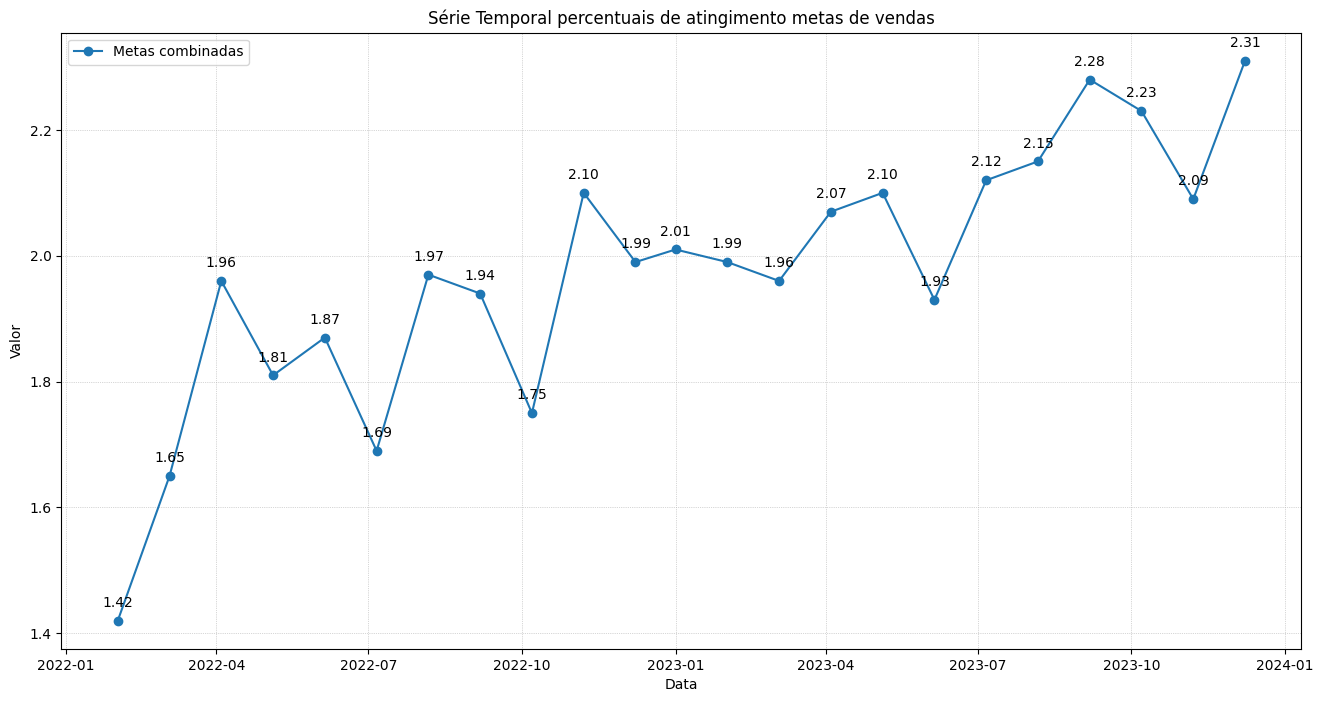

In [5]:
# Agrupa os dados pela data e soma os valores
df_grouped = df.groupby('Month/Year').sum().reset_index()

# Plota a série temporal
plt.figure(figsize=(16, 8))
plt.plot(df_grouped['Month/Year'], df_grouped['Value'], marker='o', label = "Metas combinadas")
plt.title('Série Temporal percentuais de atingimento metas de vendas')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True, linestyle=":", linewidth=.5)
for x,y in zip(df_grouped['Month/Year'], df_grouped['Value']):
  label = "{:.2f}".format(y)
  plt.annotate(label, (x,y),textcoords='offset points',
               xytext=(0,10), ha='center')

plt.show()

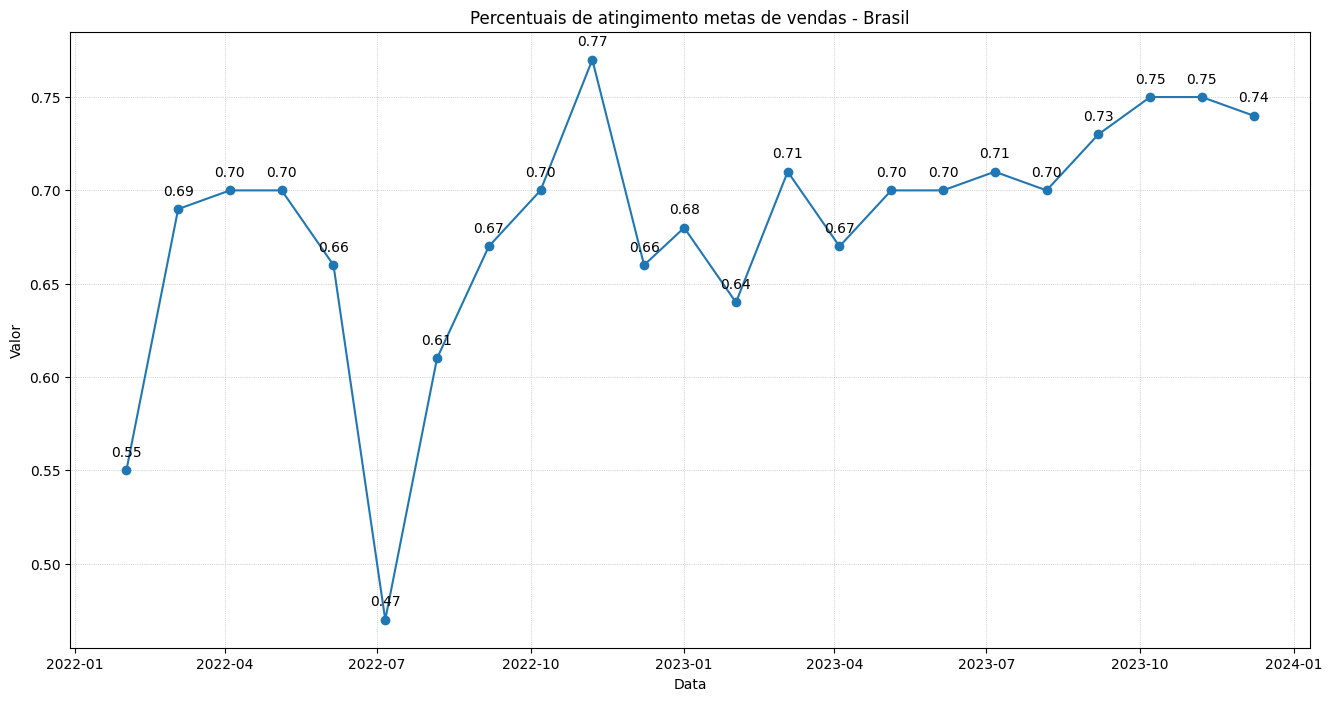

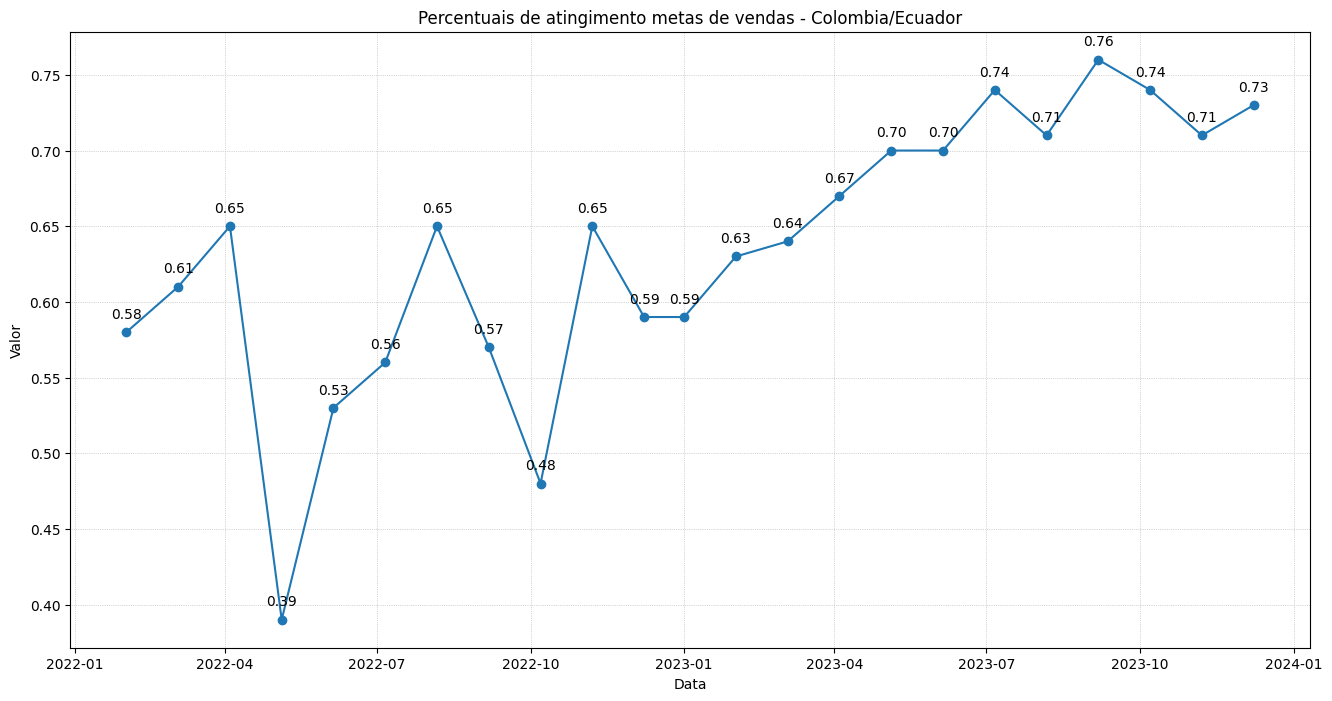

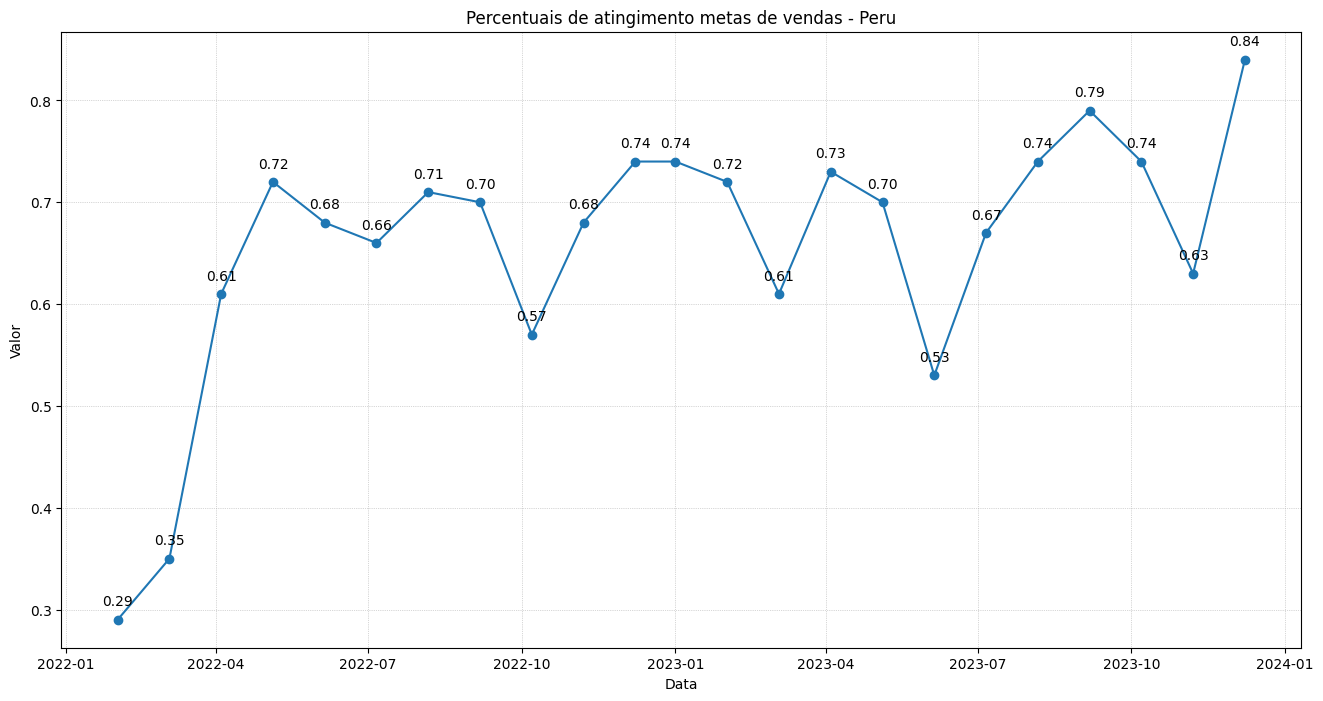

In [44]:
df_grouped = df.groupby(['Country', 'Month/Year'], as_index=False)['Value'].sum()
# Filtra e plota o gráfico para cada país
countries = df_grouped['Country'].unique()

for country in countries:
    df_country = df_grouped[df_grouped['Country'] == country]
    
    plt.figure(figsize=(16, 8))
    plt.plot(df_country['Month/Year'], df_country['Value'], marker='o')
    plt.title(f'Percentuais de atingimento metas de vendas - {country}')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.grid(linestyle=":", linewidth=.5)
    for x,y in zip(df_country['Month/Year'], df_country['Value']):
        label = "{:.2f}".format(y)
        plt.annotate(label, (x,y),textcoords='offset points',
                    xytext=(0,10), ha='center')
    plt.show()

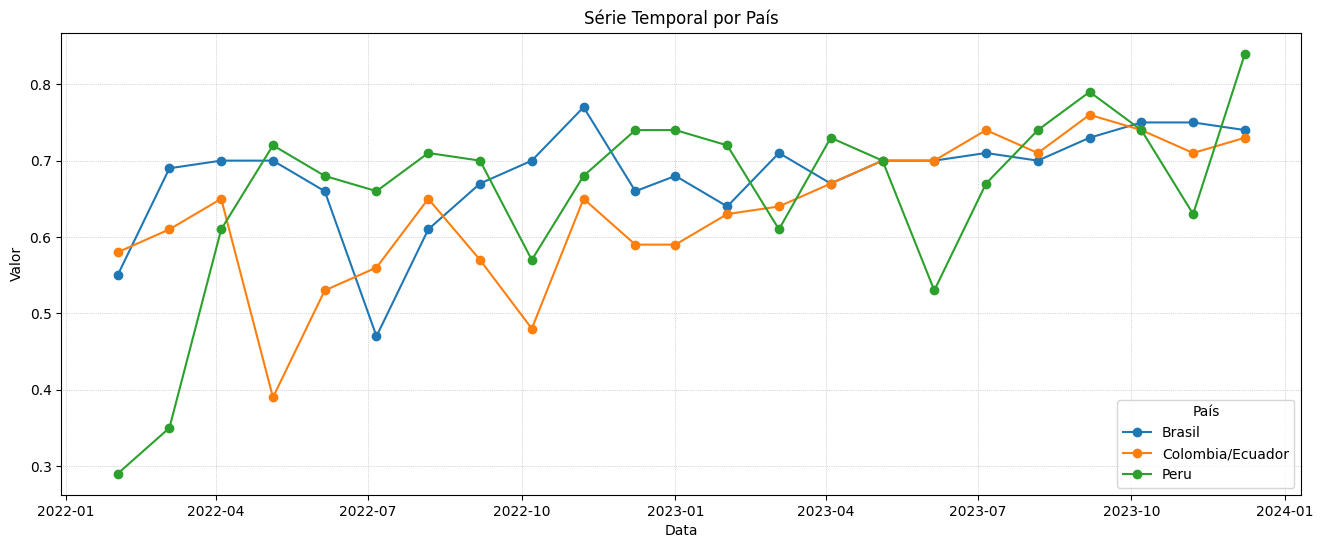

In [54]:
# Agrupa os dados por país e data, e soma os valores
df_grouped = df.groupby(['Country', 'Month/Year'], as_index=False)['Value'].sum()

# Cria o gráfico combinado
plt.figure(figsize=(16, 6))

# Plota cada país no mesmo gráfico
for country in df_grouped['Country'].unique():
    df_country = df_grouped[df_grouped['Country'] == country]
    plt.plot(df_country['Month/Year'], df_country['Value'], marker='o', label=country)

# Personaliza o gráfico
plt.title('Série Temporal por País')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend(title='País', loc='lower right')
plt.grid(linestyle=":", linewidth=.5)
plt.show()

# Machine Learning

### ARIMA e SARIMAX

In [ ]:
# Definindo uma função para ajustar o modelo SARIMA para cada país
def sarima_forecast(country_data):
    # Ordenando os dados por df
    country_data = country_data.sort_values('Month/Year')
    country_data.set_index('Month/Year', inplace=True)

    # Dividindo os dados em treino e teste
    train = country_data.iloc[:-1]  # Usando todos os dados exceto o último mês
    test = country_data.iloc[-1:]   # Usando o último mês para teste (Dez-2023)

    # Ajustando o modelo SARIMA
    model = SARIMAX(train['Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=False)

    # Fazendo a previsão para Jan-2024
    forecast = model_fit.predict(start=len(train), end=len(train))

    return forecast.values[0], test['Value'].values[0]

# Obtendo a lista de países
countries = df['Country'].unique()

# Dicionário para armazenar previsões
forecasts = {}

# Loop através de cada país
for country in countries:
    country_data = df[df['Country'] == country][['Month/Year', 'Value']]
    forecast, actual = sarima_forecast(country_data)
    forecasts[country] = forecast
    print(f"País: {country}, Previsão para Jan-2024: {forecast:.2f}")

# Convertendo as previsões em um DataFrame
forecast_df = pd.DataFrame(list(forecasts.items()), columns=['Country', 'Jan-2024 Forecast'])
print(forecast_df)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p

País: Colombia/Ecuador, Previsão para Jan-2024: 0.71


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


País: Peru, Previsão para Jan-2024: 0.61
País: Brasil, Previsão para Jan-2024: 0.69
            Country  Jan-2024 Forecast
0  Colombia/Ecuador           0.713550
1              Peru           0.608557
2            Brasil           0.685556


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Prophet

In [ ]:
# Carregando os dados
data = pd.read_excel('Forecast Value.xlsx')

# Renomeando colunas para o formato exigido pelo Prophet
data = data.rename(columns={'Month/Year': 'ds', 'Value': 'y'})

# Lista de países
countries = data['Country'].unique()

# Dicionário para armazenar previsões
forecasts = {}

# Loop através de cada país
for country in countries:
    country_data = data[data['Country'] == country][['ds', 'y']]

    # Inicializando o modelo Prophet
    model = Prophet()
    model.fit(country_data)

    # Criando dataframe para datas futuras
    future = model.make_future_dataframe(periods=1, freq='M')  # Prevendo 1 mês à frente
    forecast = model.predict(future)

    # Extraindo a previsão para Jan-2024
    jan_2024_forecast = forecast['yhat'].values[0] # [forecast['ds'] == '2023-12-01']
    forecasts[country] = jan_2024_forecast
    print(f"País: {country}, Previsão para Jan-2024: {jan_2024_forecast:.2f}")

# Convertendo as previsões em um DataFrame
forecast_df = pd.DataFrame(list(forecasts.items()), columns=['Country', 'Jan-2024 Forecast'])
print(forecast_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnwx9rx91/lsjjjm6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnwx9rx91/o7q8kwdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7193', 'data', 'file=/tmp/tmpnwx9rx91/lsjjjm6l.json', 'init=/tmp/tmpnwx9rx91/o7q8kwdp.json', 'output', 'file=/tmp/tmpnwx9rx91/prophet_modelb159h2lw/prophet_model-20240903014008.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:40:08 - cmdstanpy - INFO - Chain [1] start processing
IN

País: Colombia/Ecuador, Previsão para Jan-2024: 0.52


01:40:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnwx9rx91/38_lzzww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnwx9rx91/xn1notni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27046', 'data', 'file=/tmp/tmpnwx9rx91/38_lzzww.json', 'init=/tmp/tmpnwx9rx91/xn1notni.json', 'output', 'file=/tmp/tmpnwx9rx91/prophet_modell7prbzju/prophet_model-20240903014009.csv', 'method=optimi

País: Peru, Previsão para Jan-2024: 0.54


01:40:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


País: Brasil, Previsão para Jan-2024: 0.62
            Country  Jan-2024 Forecast
0  Colombia/Ecuador           0.523467
1              Peru           0.543635
2            Brasil           0.621088


### Random Forest & Gradient Boosting

In [ ]:
# Carregando os dados
data = pd.read_excel('Forecast Value.xlsx')

# Função para criar features de lag
def create_lag_features(df, lags):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Value'].shift(lag)
    return df

# Lista de países
countries = data['Country'].unique()

# Dicionário para armazenar previsões
rf_forecasts, gb_forecasts = {},  {}

# Loop através de cada país
for country in countries:
    country_data = data[data['Country'] == country].copy()
    country_data['Month/Year'] = pd.to_datetime(country_data['Month/Year'])
    country_data = country_data.sort_values('Month/Year')

    # Criando features de lag
    country_data = create_lag_features(country_data, lags=3)

    # Removendo linhas com valores nulos gerados pelos lags
    country_data = country_data.dropna()

    # Separando features e target
    X = country_data[['lag_1', 'lag_2', 'lag_3']]
    y = country_data['Value']

    # Usando todos os dados para treinar e prever Jan-2024
    # Usando os últimos 3 valores como input
    last_values = X.iloc[-1].values.reshape(1, -1)

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    rf_forecast = rf_model.predict(last_values)[0]
    rf_forecasts[country] = rf_forecast

    # Gradient Boosting
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    gb_model.fit(X, y)
    gb_forecast = gb_model.predict(last_values)[0]
    gb_forecasts[country] = gb_forecast

    print(f"País: {country}, RF Previsão para Jan-2024: {rf_forecast:.2f}, GB Previsão para Jan-2024: {gb_forecast:.2f}")

# Convertendo as previsões em DataFrames
rf_forecast_df = pd.DataFrame(list(rf_forecasts.items()), columns=['Country', 'Jan-2024 RF Forecast'])
gb_forecast_df = pd.DataFrame(list(gb_forecasts.items()), columns=['Country', 'Jan-2024 GB Forecast'])

# Combinando resultados
combined_forecasts = rf_forecast_df.merge(gb_forecast_df, on='Country')
print(combined_forecasts)


País: Colombia/Ecuador, RF Previsão para Jan-2024: 0.73, GB Previsão para Jan-2024: 0.73
País: Peru, RF Previsão para Jan-2024: 0.78, GB Previsão para Jan-2024: 0.84
País: Brasil, RF Previsão para Jan-2024: 0.74, GB Previsão para Jan-2024: 0.74
            Country  Jan-2024 RF Forecast  Jan-2024 GB Forecast
0  Colombia/Ecuador                0.7340              0.730899
1              Peru                0.7789              0.840040
2            Brasil                0.7412              0.740625


### LSTM

In [37]:
# Carregando os dados
data = pd.read_excel('Forecast Value.xlsx')

# Lista de países
countries = data['Country'].unique()

# Dicionário para armazenar previsões
lstm_forecasts = {}

# Definindo parâmetros
n_steps = 5  # Número de lags
n_features = 1

# Loop através de cada país
for country in countries:
    country_data = data[data['Country'] == country].copy()
    country_data['Month/Year'] = pd.to_datetime(country_data['Month/Year'])
    country_data = country_data.sort_values('Month/Year')

    # Extraindo a série temporal
    series = country_data['Value'].values.reshape(-1,1)

    # Normalizando os dados
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_series = scaler.fit_transform(series)

    # Preparando os dados em formato adequado para LSTM
    X, y = [], []
    for i in range(n_steps, len(scaled_series)):
        X.append(scaled_series[i - n_steps:i, 0])
        y.append(scaled_series[i, 0])
    X, y = np.array(X), np.array(y)

    # Remodelando X para o formato [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # Definindo o modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Treinando o modelo
    model.fit(X, y, epochs=200, verbose=0)

    # Preparando os últimos n_steps para previsão
    last_steps = scaled_series[-n_steps:]
    last_steps = last_steps.reshape((1, n_steps, n_features))

    # Fazendo a previsão
    yhat = model.predict(last_steps, verbose=0)
    # Invertendo a normalização
    forecast = scaler.inverse_transform(yhat)[0][0]

    lstm_forecasts[country] = forecast
    # print(f"País: {country}, LSTM Previsão para Jan-2024: {forecast:.2f}")

# Convertendo as previsões em um DataFrame
lstm_forecast_df = pd.DataFrame(list(lstm_forecasts.items()), columns=['Country', 'Jan-2024 LSTM Forecast'])
print(lstm_forecast_df)

País: Colombia/Ecuador, LSTM Previsão para Jan-2024: 0.75
País: Peru, LSTM Previsão para Jan-2024: 0.75
País: Brasil, LSTM Previsão para Jan-2024: 0.72
            Country  Jan-2024 LSTM Forecast
0  Colombia/Ecuador                0.754895
1              Peru                0.748711
2            Brasil                0.722648


# Conclusão

De acordo com os testes realizados acima podemos concluir que os modelos mais tradicionais de Séries temporárais, como ARIMA e Prophet não realizaram uma performance esperada. Por outro lado, podemos verificar que modelos mais tradicionais do aprendizado de máquina (Machine Learning) realizarm performances mais interessantes. Com destaque para o gradient Boosting e para a rede neural LSTM - Long Short Term Memory.  